# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где: 
   - 0 — совершенно неудовлетворён, 
   - 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Нужно решить две задачи:
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 1: предсказание уровня удовлетворённости сотрудника

# Описание данных

Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за - последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Загрузка данных

In [1]:
!pip install phik -q
!pip install optuna-integration -q
!pip install imbalanced-learn -q
!pip install shap -q

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import scipy.stats as st
import random
import shap
RANDOM_STATE = 42
TEST_SIZE = 0.25

from matplotlib import pyplot as plt
from phik import resources, report
from scipy.stats import spearmanr

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder,\
PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score,\
                            f1_score, roc_auc_score 
from sklearn.multiclass import OneVsRestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score,\
                                    GridSearchCV, RandomizedSearchCV, train_test_split

from optuna.integration import OptunaSearchCV 

In [3]:
RANDOM_STATE=42
TEST_SIZE=0.25

In [4]:
# Тренировочная выборка:

try:
    # локальный путь к файлу, который открывается у меня
    train_job_satisfaction_rate = pd.read_csv('train_job_satisfaction_rate.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')

train_job_satisfaction_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


In [5]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
train_job_satisfaction_rate = train_job_satisfaction_rate.sort_values(by = 'id')

Есть пропуски. Тип данных правильный

In [7]:
# Входные признаки тестовой выборки:

try:
    # локальный путь к файлу, который открывается у меня
    test_features = pd.read_csv('test_features.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    test_features = pd.read_csv('/datasets/test_features.csv')
    
test_features

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [9]:
test_features = test_features.sort_values(by = 'id')

Есть пропуски. Тип данных правильный

In [10]:
# Целевой признак тестовой выборки:

try:
    # локальный путь к файлу, который открывается у меня
    test_target_job_satisfaction_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

test_target_job_satisfaction_rate

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
...,...,...
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26


In [11]:
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.sort_values(by = 'id')

In [12]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1734 to 334
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB


Пропусков нет. Тип данных правильный.

<font color='Black'><b>Вывод после загрузки и изучения данных:  </b></font><br>

- Названия столбцов выполнены в «змеином_регистре».
- В данных есть пропуски.
- Данные в таблицах соответствуют описанию.
- Тип данных в файлах правильный.

## Предобработка данных

2.1 Обработка пропусков 

In [13]:
train_job_satisfaction_rate.index[train_job_satisfaction_rate.isna().any(axis=1)].tolist()

[1745, 2975, 1469, 1633, 2781, 1209, 3866, 1526, 1630, 2522]

In [14]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Всего 10 пропусков: 
- отдел, в котором работает сотрудник 'dept' - 6 пропусков;
- уровень занимаемой должности 'level' - 4 пропуска.

In [15]:
test_features.index[test_features.isna().any(axis=1)].tolist()

[312, 191, 1196]

In [16]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Всего 3 пропуска:

- отдел, в котором работает сотрудник 'dept' - 2 пропуска;
- уровень занимаемой должности 'level' - 1 пропуск.

2.2 Обработка дубликатов

In [17]:
train_job_satisfaction_rate.duplicated().sum()

0

In [18]:
test_features.duplicated().sum()

0

In [19]:
test_target_job_satisfaction_rate.duplicated().sum()

0

<font color='Black'><b>Общий вывод после предобработки данных:  </b></font><br>

- обнаружили пропуски, заполним их позже в пайплайне;
- проверили наличие дубликатов.

## Исследовательский анализ данных

Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

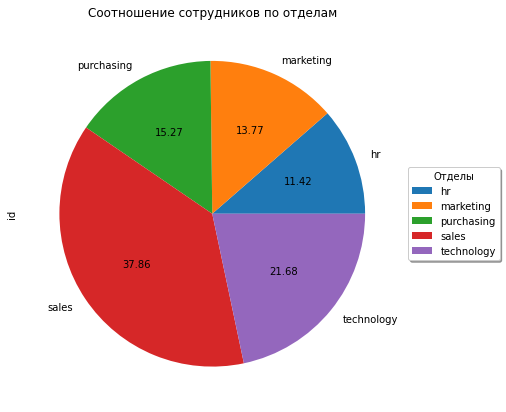

In [20]:
train_job_satisfaction_rate.pivot_table(index='dept', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(7, 7), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Отделы',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по отделам')
plt.tight_layout()  
plt.show()

In [21]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior', regex=True)

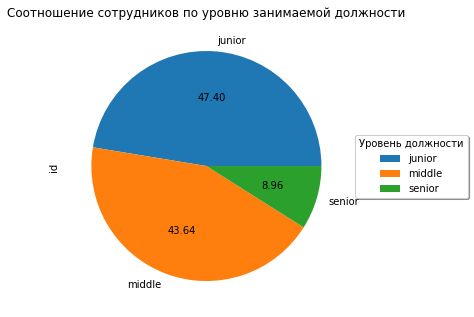

In [22]:
train_job_satisfaction_rate.pivot_table(index='level', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(6, 6), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Уровень должности',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по уровню занимаемой должности')
plt.tight_layout()  
plt.show()

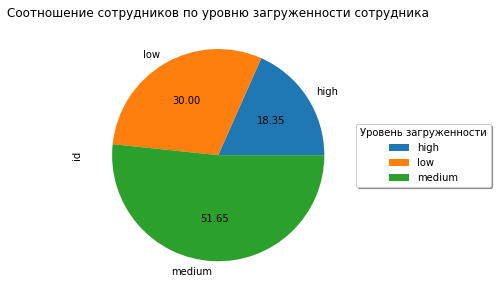

In [23]:
train_job_satisfaction_rate.pivot_table(index='workload', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(6, 6), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Уровень загруженности',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по уровню загруженности сотрудника')
plt.tight_layout()  
plt.show()

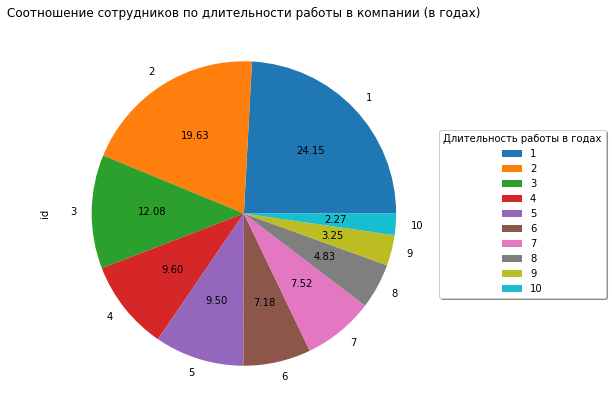

In [24]:
train_job_satisfaction_rate.pivot_table(index='employment_years', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(8, 8), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Длительность работы в годах',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по длительности работы в компании (в годах)')
plt.tight_layout()  
plt.show()

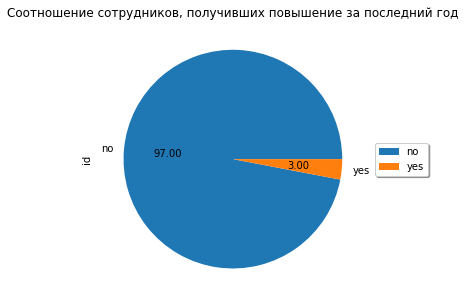

In [25]:
train_job_satisfaction_rate.pivot_table(index='last_year_promo', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(5, 5), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников, получивших повышение за последний год')
plt.tight_layout()  
plt.show()

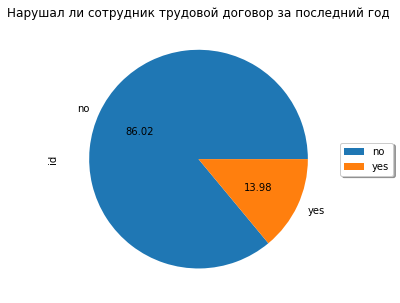

In [26]:
train_job_satisfaction_rate.pivot_table(index='last_year_violations', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(5, 5), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Нарушал ли сотрудник трудовой договор за последний год')
plt.tight_layout()  
plt.show()

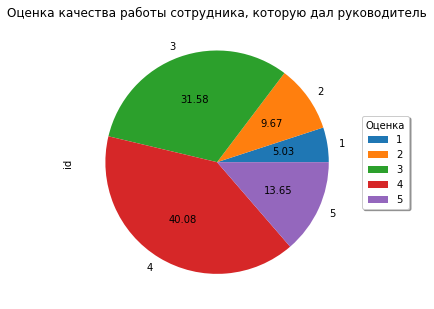

In [27]:
train_job_satisfaction_rate.pivot_table(index='supervisor_evaluation', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(5, 5), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Оценка', 
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Оценка качества работы сотрудника, которую дал руководитель')
plt.tight_layout()  
plt.show()

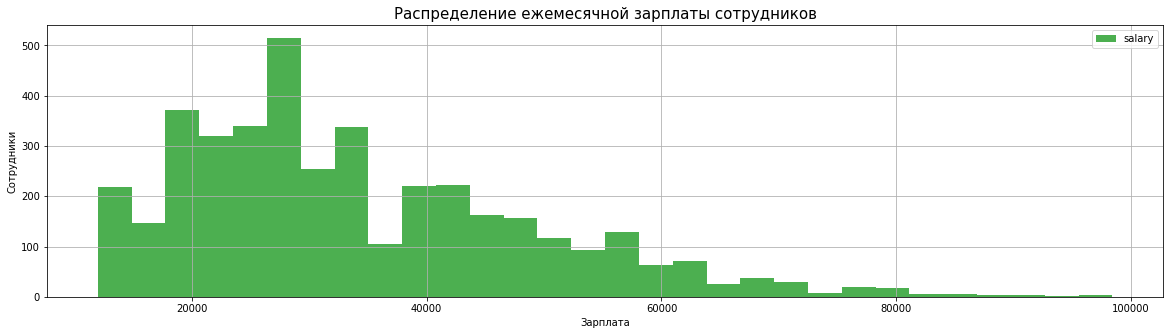

In [28]:
train_job_satisfaction_rate['salary'].plot(kind = 'hist', color='#4CAF50', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Распределение ежемесячной зарплаты сотрудников', fontsize=15)
plt.xlabel('Зарплата')
plt.ylabel('Сотрудники')
plt.grid(True)
plt.show()

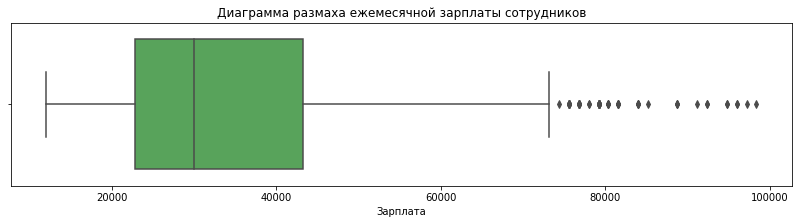

In [29]:
plt.figure(figsize=(14,3))
sns.boxplot(x='salary',data=train_job_satisfaction_rate, color='#4CAF50')
plt.title('Диаграмма размаха ежемесячной зарплаты сотрудников', fontsize=12)
plt.xlabel('Зарплата')
plt.show()

In [30]:
train_job_satisfaction_rate['salary'].describe()

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

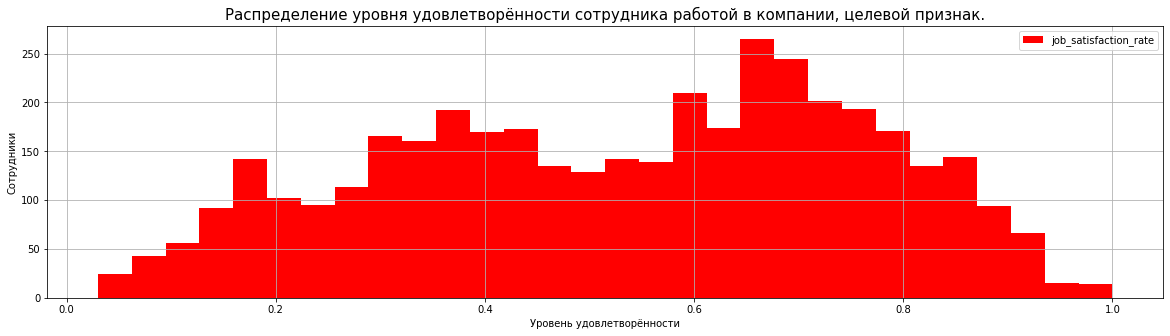

In [31]:
train_job_satisfaction_rate['job_satisfaction_rate'].plot(kind = 'hist', color='red', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Распределение уровня удовлетворённости сотрудника работой в компании, целевой признак.', fontsize=15)
plt.xlabel('Уровень удовлетворённости')
plt.ylabel('Сотрудники')
plt.grid(True)
plt.show()

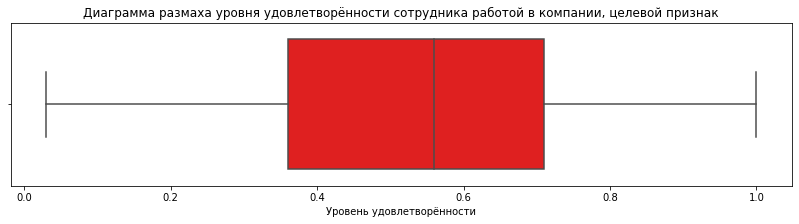

In [32]:
plt.figure(figsize=(14,3))
sns.boxplot(x='job_satisfaction_rate',data=train_job_satisfaction_rate, color='red')
plt.title('Диаграмма размаха уровня удовлетворённости сотрудника работой в компании, целевой признак', fontsize=12)
plt.xlabel('Уровень удовлетворённости')
plt.show()

In [33]:
train_job_satisfaction_rate['job_satisfaction_rate'].describe()

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


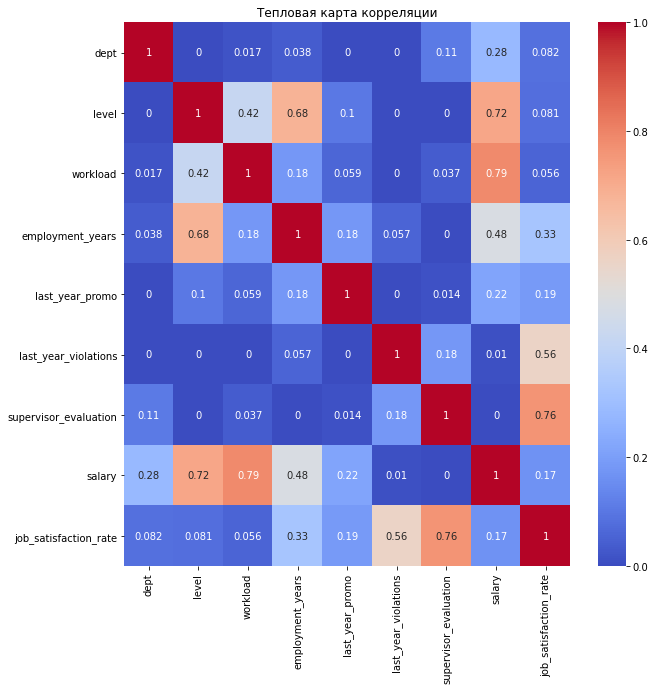

In [34]:
df = train_job_satisfaction_rate.drop(['id'], axis=1)
phik_matrix = df.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()

У целевого признака уровень удовлетворённости сотрудника работой в компании есть корреляция с данными:
-  оценка качества работы сотрудника, которую дал руководитель;

Также есть корреляция у признаков:
- уровень занимаемой должности и длительность работы в компании (в годах);
- уровень занимаемой должности и  ежемесячная зарплата сотрудника;
- уровень загруженности сотрудника и ежемесячная зарплата сотрудника;

In [35]:
def chart_hist_(df, col, target, xlabel_rotation=0):
    sns.set()
    f, axes = plt.subplots(1, 1, figsize=(14, 6))
    axes.set_title(f'Гистограмма для {col}', fontsize=10)
    axes.set_ylabel('Количество', fontsize=12)
    plt.xticks(rotation=xlabel_rotation)  # Установка наклона подписей по оси x
    if target != None:
        sns.histplot(df, bins=25, kde=True, ax=axes, hue=target, x=col)
    else:
        sns.histplot(df, bins=25, kde=True, ax=axes, x=col)
    plt.show()

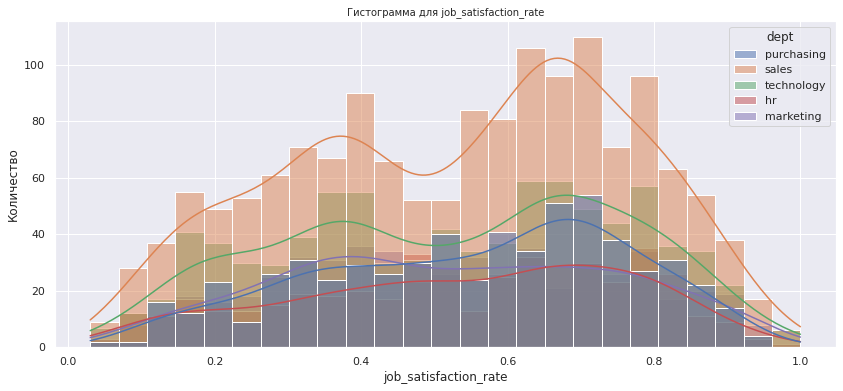

In [36]:
chart_hist_(train_job_satisfaction_rate, 'job_satisfaction_rate', 'dept')

На этом графике видим, что уровень удовлетворённости сотрудника работой в компании во всех отделах примерно одинаковая

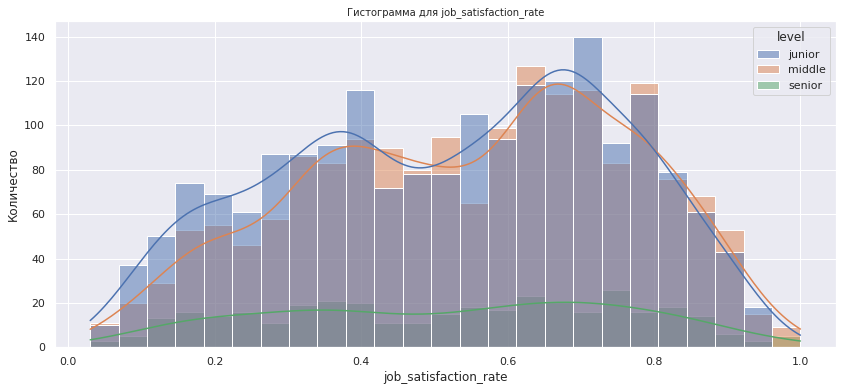

In [37]:
chart_hist_(train_job_satisfaction_rate, 'job_satisfaction_rate', 'level')

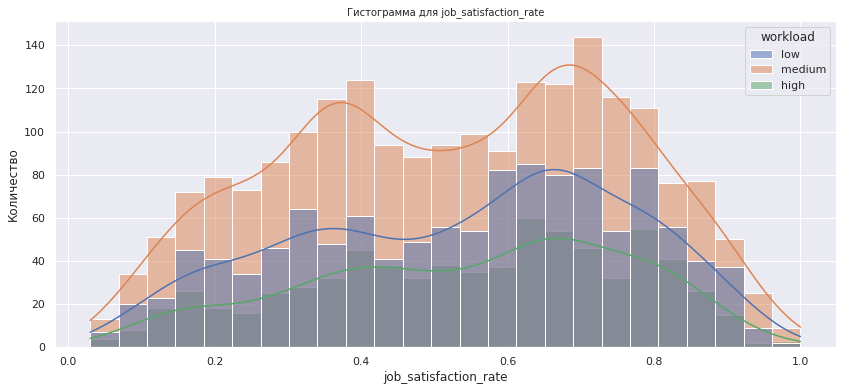

In [38]:
chart_hist_(train_job_satisfaction_rate, 'job_satisfaction_rate', 'workload')

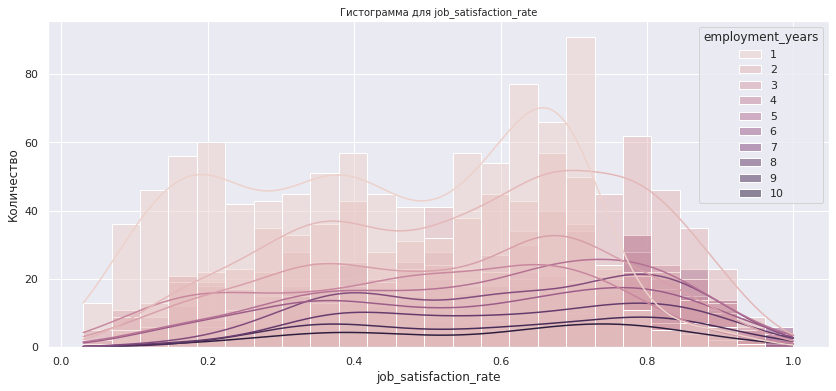

In [39]:
chart_hist_(train_job_satisfaction_rate, 'job_satisfaction_rate', 'employment_years')

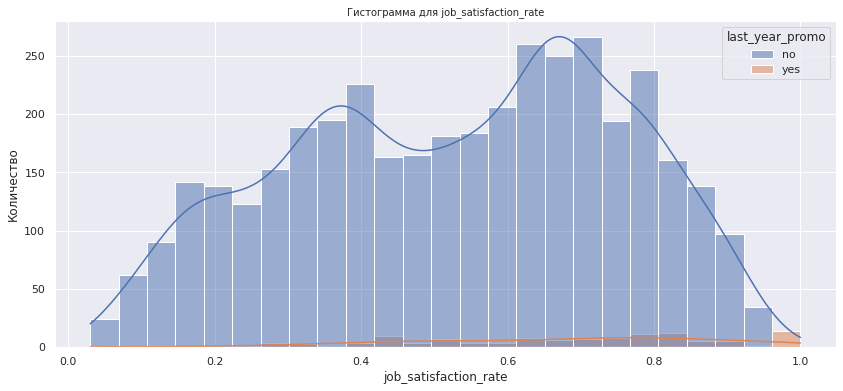

In [40]:
chart_hist_(train_job_satisfaction_rate, 'job_satisfaction_rate', 'last_year_promo')

По этому графику видим, что полностью удовлетворёны работой в компании (уровень 1.0) сотрудники, получившие повышение за последний год

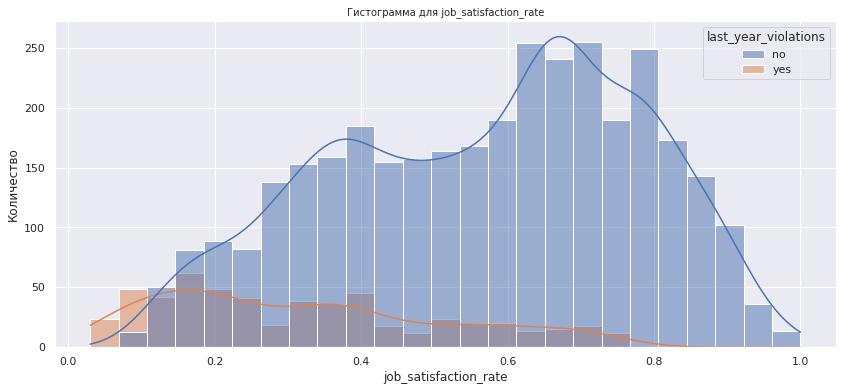

In [41]:
chart_hist_(train_job_satisfaction_rate, 'job_satisfaction_rate', 'last_year_violations')

Нашли!:) Сотрудники, нарушавшие трудовой договор за последний год, имеют низкий уровень удовлетворённости работой в компании.

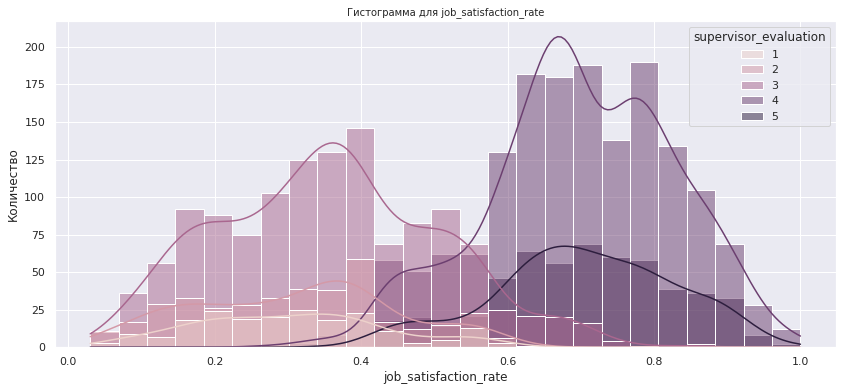

In [42]:
chart_hist_(train_job_satisfaction_rate, 'job_satisfaction_rate', 'supervisor_evaluation')

Сотрудники, получившие оценку качества работы "4" и "5" (высшие оценки), имеют высокий уровень удовлетворённости работой в компании.

<font color='Black'><b>Вывод после исследовательского анализа данных:  </b></font><br>

Соотношение сотрудников по отделам:
- отдел sales - 38%
- отдел technology - 22%
- отдел purchasing - 15%
- отдел marketing - 14%
- отдел hr - 11%.

Соотношение сотрудников по уровню занимаемой должности:
- Junior - 47%
- Middle - 44%
- Senior - 9%

Соотношение сотрудников по уровню загруженности сотрудника:
- low 30%
- medium 52%
- high - 18%

Соотношение сотрудников по длительности работы в компании:
- 24% работают один год
- 20% работают два года
- 12% работают три года
- 10% работают четыре года
- 10% работают пять лет
- 7% работают шесть лет
- 8% работают семь лет
- 5% работают восемь лет
- 3% работают девять лет
- 2% работают десять лет

Оценка качества работы сотрудника, которую дал руководитель (от 1 до 5):
- Оценка "1" - получили 5% сотрудников
- Оценка "2"- получили 10% сотрудников
- Оценка "3"- получили 32% сотрудников
- Оценка "4"- получили 40% сотрудников
- Оценка "5"- получили 14% сотрудников.

Сотрудники, получившие оценку качества работы "4" и "5" (высшие оценки), имеют высокий уровень удовлетворённости работой в компании.


Зарплаты сотрудников:
- Средняя зарплата     33 927 тыс
- Минимальная зарплата      12 000 тыс
- Максимальная зарплата      98 400 тыс
- Большая часть зарплат имеет диапазон 22 800 - 43 200 тыс

Уровень удовлетворённости сотрудника работой в компании, целевой признак:
- Максимальное значение   1.0
- Минимальное значение    0.03
- Среднее значение по компании    0.53
- Большая часть результатов лежит в диапазоне 0.36 - 0.71

Получили повышение за последний год 3% сотрудников.
Полностью удовлетворёны работой в компании (уровень 1.0) сотрудники, получившие повышение за последний год.

Нарушали трудовой договор за последний год 14% сотрудников.
Сотрудники, нарушавшие трудовой договор за последний год, имеют низкий уровень удовлетворённости работой в компании.



У целевого признака уровень удовлетворённости сотрудника работой в компании есть корреляция с данными:
- оценка качества работы сотрудника, которую дал руководитель;

Также есть корреляция у признаков:
- уровень занимаемой должности и длительность работы в компании (в годах);
- уровень занимаемой должности и ежемесячная зарплата сотрудника;
- уровень загруженности сотрудника и ежемесячная зарплата сотрудника;


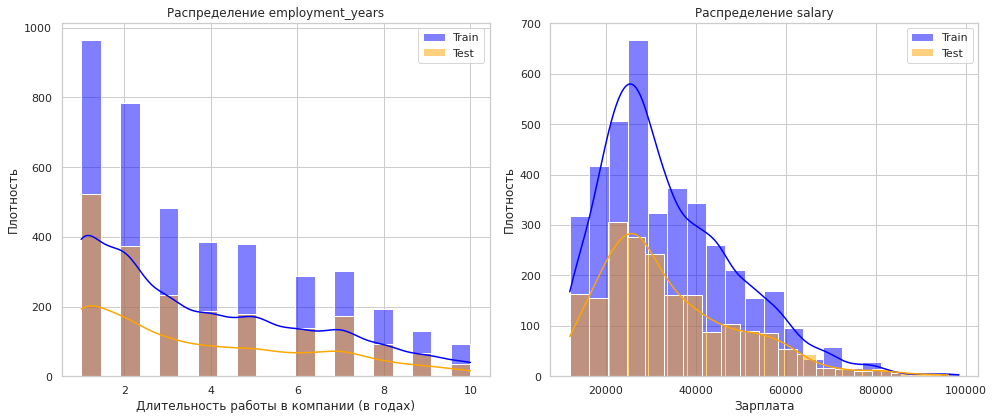

In [43]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Сравнение распределений для employment_years
plt.subplot(1, 2, 1)
sns.histplot(train_job_satisfaction_rate['employment_years'], color='blue', 
             alpha=0.5, label='Train', kde=True, bins=20)
sns.histplot(test_features['employment_years'], color='orange', 
             alpha=0.5, label='Test', kde=True, bins=20)
plt.title('Распределение employment_years')
plt.xlabel('Длительность работы в компании (в годах)')
plt.ylabel('Плотность')
plt.legend()

# Сравнение распределений для другого признака (например, salary)
plt.subplot(1, 2, 2)
sns.histplot(train_job_satisfaction_rate['salary'], color='blue', 
             alpha=0.5, label='Train', kde=True, bins=20)
sns.histplot(test_features['salary'], color='orange', 
             alpha=0.5, label='Test', kde=True, bins=20)
plt.title('Распределение salary')
plt.xlabel('Зарплата')
plt.ylabel('Плотность')
plt.legend()

plt.tight_layout()
plt.show()

По графику видим, что тренировочная выборка соответствует тестовой 

## Подготовка данных

Подготовку признаков выполним в пайплайне

In [44]:
X_train = train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

X_test = test_features
y_test = test_target_job_satisfaction_rate['job_satisfaction_rate']

In [45]:
train_job_satisfaction_rate.head(2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
560,100954,purchasing,junior,low,1,no,no,4,15600,0.60
1124,101057,sales,junior,low,1,no,yes,4,19200,0.45


In [46]:
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']

num_columns = ['employment_years', 
               'supervisor_evaluation', 
               'salary']

In [47]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [48]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes'],
                ], 
                handle_unknown='use_encoded_value' , unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [49]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

## Обучение моделей

In [50]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Выбираем подходящие модели для регрессионной задачи, где целевая переменная (y) содержит непрерывные числовые значения:  

In [51]:
param_grid = [
    # Словарь для DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE, criterion='friedman_mse')],
        'models__max_depth': [3, 4, 5, 6, None],
        'models__min_samples_leaf': [1, 2, 4, 8],
        'models__max_features': ['auto', 'sqrt', 0.8],
        'models__criterion': ['squared_error', 'absolute_error'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для KNeighborsRegressor
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': list(range(3, 15)),
        'models__weights': ['uniform', 'distance'],
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для RandomForestRegressor
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],  # Исправлено: models__ вместо model__
        'models__max_depth': [3, 5, None],   # Исправлено: models__ вместо model__
        'models__min_samples_leaf': [1, 2, 4],  # Исправлено: models__ вместо model__
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Качество модели проверим на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

In [52]:
def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    smape_value = np.mean(
        np.where(denominator != 0, 
                200 * np.abs(y_pred - y_true) / denominator, 
                0)
    )
    return smape_value

In [53]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [54]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=15,
    n_iter=50,
    n_jobs=-1,
    scoring=smape_scorer,
    random_state=RANDOM_STATE
)

In [55]:
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
225 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/conda/lib/pytho

RandomizedSearchCV(cv=15,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord'...
                                         'models__max_depth': [3, 5, None],
                                         'models__min_samples_leaf': [1, 2, 4],
                                         'models__n_estimators': [100, 200],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [56]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика smape для лучшей модели:\n', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                           

Реальное SMAPE = 12.88% (модуль от числа)

Критерий успеха достигнут! (12.88% ≤ 15%)

In [57]:
y_test_pred = randomized_search.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [58]:
test_smape = smape(y_test, y_test_pred)
print(f"SMAPE на тестовой выборке: {test_smape:.2f}%")

# Проверка критерия
if test_smape <= 15:
    print("✅ Модель прошла критерий успеха (SMAPE ≤ 15%)")
else:
    print("❌ Модель не соответствует критерию")

SMAPE на тестовой выборке: 13.09%
✅ Модель прошла критерий успеха (SMAPE ≤ 15%)


## Оформление выводов

<font color='Black'><b>Вывод после обучения модели:  </b></font><br>

Мы обучили 4 модели: DecisionTreeRegressor, KNeighborsRegressor, RandomForestRegressor  и LinearRegression, в качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели мы создали метрику SMAPE («симметричное среднее абсолютное процентное отклонение») По итогам подбора лучшей моделью стала модель RandomForestRegressor. Метрика SMAPE на тестовой выборке - 12.89%.

# Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи используем те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

## Загрузка данных

In [59]:
# Тренировочная выборка:

try:
    # локальный путь к файлу, который открывается у меня
    train_quit = pd.read_csv('train_quit.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    train_quit = pd.read_csv('/datasets/train_quit.csv')

train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


In [60]:
train_quit = train_quit.sort_values(by = 'id')

In [61]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2600 to 2120
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 343.8+ KB


Пропусков нет. Тип данных правильный.

In [62]:
# Целевой признак тестовой выборки:

try:
    # локальный путь к файлу, который открывается у меня
    test_target_quit = pd.read_csv('test_target_quit.csv')
except:
    # Путь к файлу который открывается в тренажёре/у ревьювера
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

test_target_quit

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


In [63]:
test_target_quit = test_target_quit.sort_values(by = 'id')

In [64]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1566 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


Пропусков нет. Тип данных правильный.

<font color='Black'><b>Вывод после загрузки и изучения данных:  </b></font><br>

- Названия столбцов выполнены в «змеином_регистре».
- В данных пропусков нет.
- Данные в таблицах соответствуют описанию.
- Тип данных в файлах правильный.
- Входные признаки тестовой выборки те же, что и в прошлой задаче

## Предобработка данных

Проверим на дубликаты:

In [65]:
train_quit.duplicated().sum()

0

In [66]:
test_target_quit.duplicated().sum()

0

<font color='Black'><b>Общий вывод после предобработки данных:  </b></font><br>
- дубликаты отсутствуют.  


## Исследовательский анализ данных

3.1. Проведем исследовательский анализ данных.

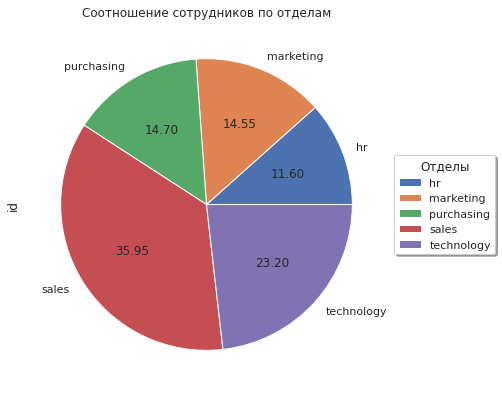

In [67]:
train_quit.pivot_table(index='dept', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(7, 7), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Отделы',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по отделам')
plt.tight_layout()  
plt.show()

In [68]:
train_quit['dept'].value_counts()

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

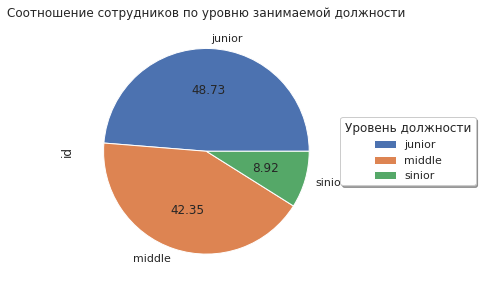

In [69]:
train_quit.pivot_table(index='level', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(6, 6), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Уровень должности',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по уровню занимаемой должности')
plt.tight_layout()  
plt.show()

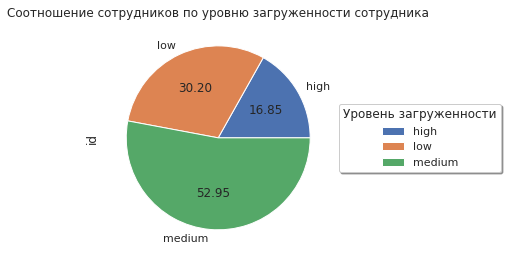

In [70]:
train_quit.pivot_table(index='workload', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(6, 6), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Уровень загруженности',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по уровню загруженности сотрудника')
plt.tight_layout()  
plt.show()

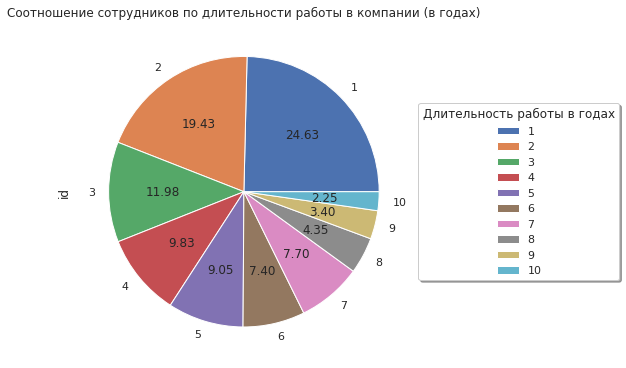

In [71]:
train_quit.pivot_table(index='employment_years', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(8, 8), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Длительность работы в годах',  
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников по длительности работы в компании (в годах)')
plt.tight_layout()  
plt.show()

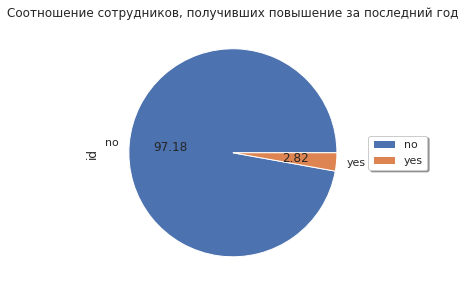

In [72]:
train_quit.pivot_table(index='last_year_promo', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(5, 5), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Соотношение сотрудников, получивших повышение за последний год')
plt.tight_layout()  
plt.show()

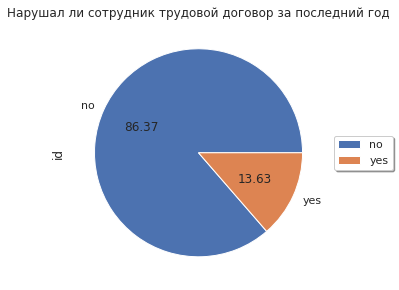

In [73]:
train_quit.pivot_table(index='last_year_violations', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(5, 5), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Нарушал ли сотрудник трудовой договор за последний год')
plt.tight_layout()  
plt.show()

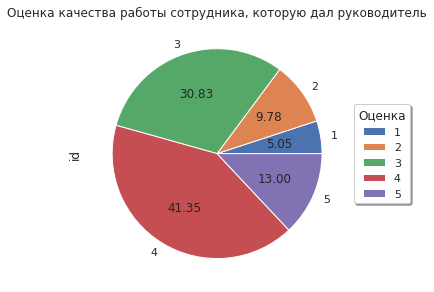

In [74]:
train_quit.pivot_table(index='supervisor_evaluation', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(5, 5), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    title='Оценка', 
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Оценка качества работы сотрудника, которую дал руководитель')
plt.tight_layout()  
plt.show()

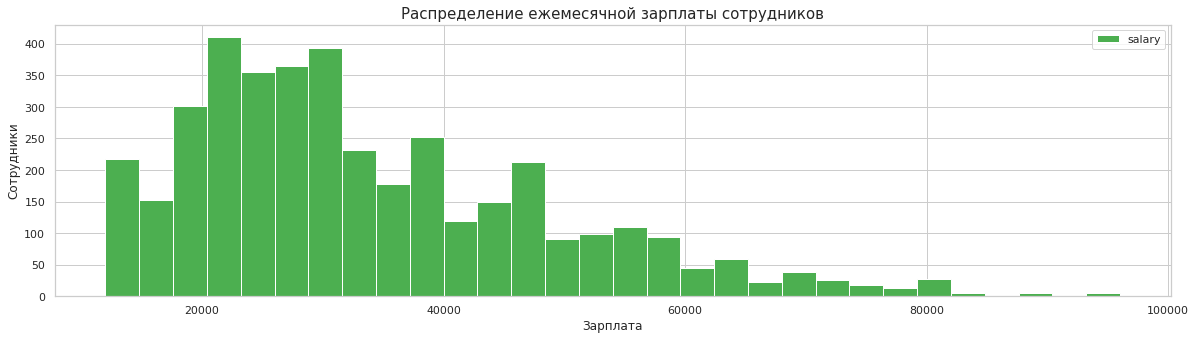

In [75]:
train_quit['salary'].plot(kind = 'hist', color='#4CAF50', bins = 30, figsize = (20, 5), grid = True, legend = True)
plt.title('Распределение ежемесячной зарплаты сотрудников', fontsize=15)
plt.xlabel('Зарплата')
plt.ylabel('Сотрудники')
plt.grid(True)
plt.show()

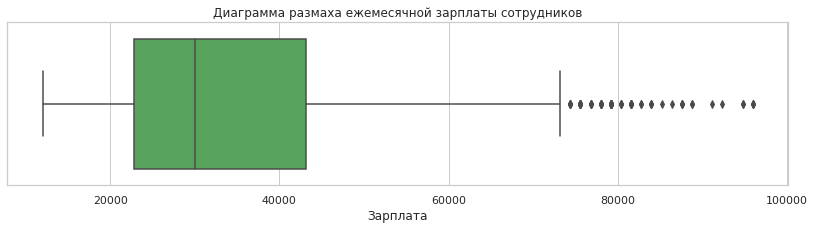

In [76]:
plt.figure(figsize=(14,3))
sns.boxplot(x='salary',data=train_quit, color='#4CAF50')
plt.title('Диаграмма размаха ежемесячной зарплаты сотрудников', fontsize=12)
plt.xlabel('Зарплата')
plt.show()

In [77]:
train_quit['salary'].describe()

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

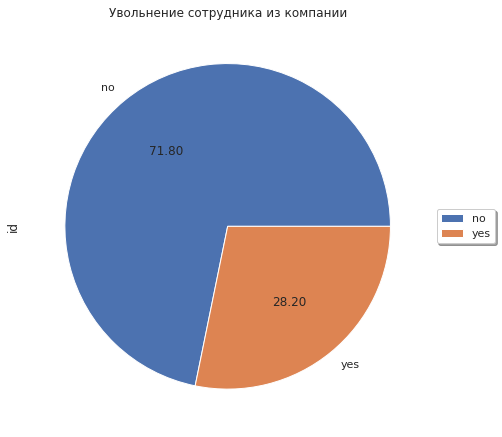

In [78]:
train_quit.pivot_table(index='quit', values='id', aggfunc='count') \
    .plot.pie(y='id', figsize=(7, 7), autopct='%.2f', legend=False)  # Отключаем встроенную легенду

plt.legend(
    bbox_to_anchor=(1, 0.5),  
    loc='center left',  
    frameon=True, 
    shadow=True  
)

plt.title('Увольнение сотрудника из компании')
plt.tight_layout()  
plt.show()

Распределения значений признаков очень похоже с распределением признаков в первой задаче.

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


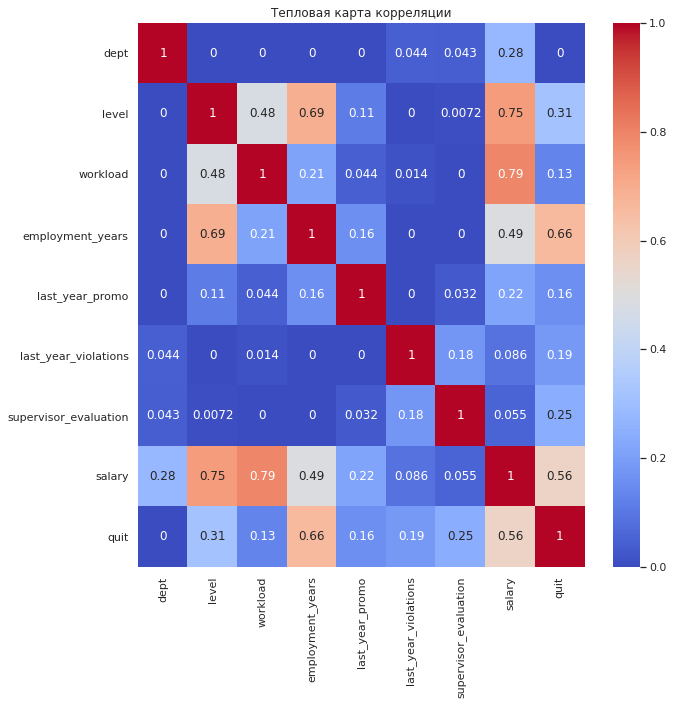

In [79]:
df = train_quit.drop(['id'], axis=1)
phik_matrix = df.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()

У целевого признака увольнение сотрудника из компании есть корреляция с данными:
-  длительность работы в компании (в годах);

3.2. Составим портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

In [80]:
train_quit_stable = train_quit.loc[train_quit['quit'] == 'no']
train_quit_stable.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2455,100469,marketing,junior,medium,1,no,no,4,28800,no
1592,100601,technology,middle,high,4,no,no,4,68400,no
1681,101047,purchasing,junior,medium,3,no,no,4,26400,no
2918,101374,technology,middle,low,8,no,no,3,22800,no
191,102155,technology,middle,high,8,no,no,4,57600,no


In [81]:
train_quit_retired = train_quit.loc[train_quit['quit'] == 'yes']
train_quit_retired.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2657,100858,sales,junior,medium,2,no,no,4,25200,yes
3072,100969,marketing,junior,medium,2,no,no,3,26400,yes
3552,102630,technology,junior,medium,2,no,no,2,30000,yes


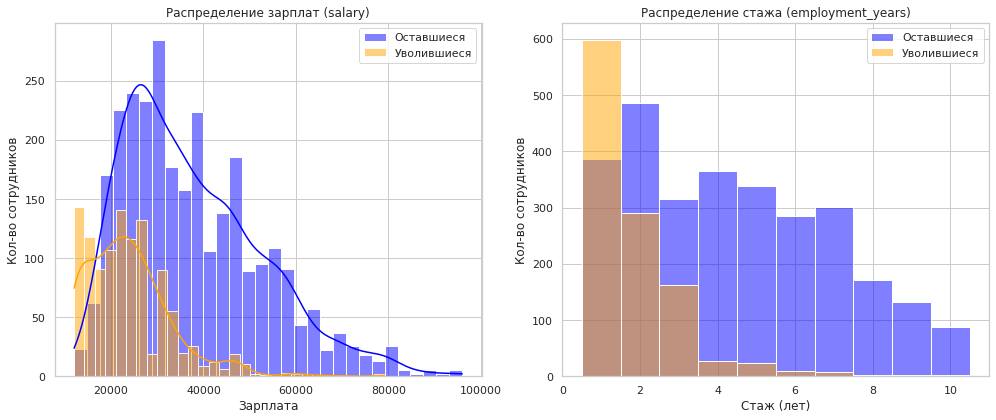

In [82]:
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# --- График для salary ---
plt.subplot(1, 2, 1)
sns.histplot(train_quit_stable['salary'], color='blue', alpha=0.5, label='Оставшиеся', kde=True, bins=30)
sns.histplot(train_quit_retired['salary'], color='orange', alpha=0.5, label='Уволившиеся', kde=True, bins=30)
plt.title('Распределение зарплат (salary)')
plt.xlabel('Зарплата')
plt.ylabel('Кол-во сотрудников')
plt.legend()

# --- График для employment_years ---
plt.subplot(1, 2, 2)
sns.histplot(train_quit_stable['employment_years'], color='blue', alpha=0.5, label='Оставшиеся', kde=False, discrete=True)
sns.histplot(train_quit_retired['employment_years'], color='orange', alpha=0.5, label='Уволившиеся', kde=False, discrete=True)
plt.title('Распределение стажа (employment_years)')
plt.xlabel('Стаж (лет)')
plt.ylabel('Кол-во сотрудников')
plt.legend()

plt.tight_layout()
plt.show()

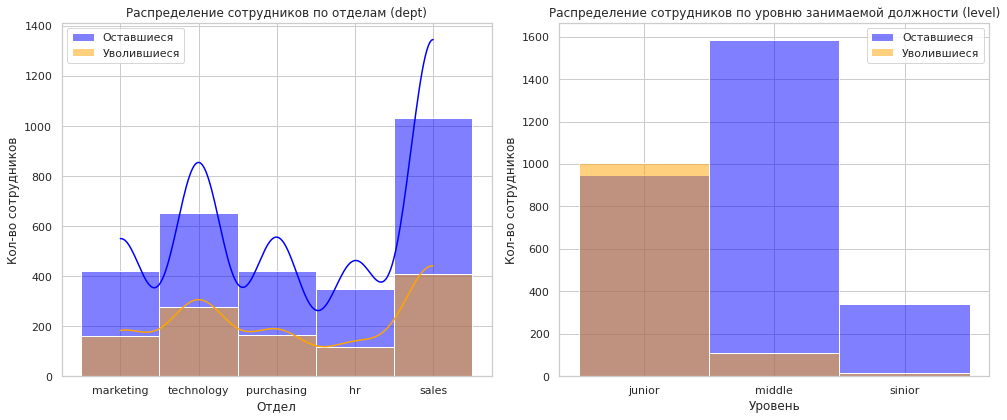

In [83]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# --- График для dept ---
plt.subplot(1, 2, 1)
sns.histplot(train_quit_stable['dept'], color='blue', alpha=0.5, label='Оставшиеся', kde=True, bins=30)
sns.histplot(train_quit_retired['dept'], color='orange', alpha=0.5, label='Уволившиеся', kde=True, bins=30)
plt.title('Распределение сотрудников по отделам (dept)')
plt.xlabel('Отдел')
plt.ylabel('Кол-во сотрудников')
plt.legend()

# --- График для level ---
plt.subplot(1, 2, 2)
sns.histplot(train_quit_stable['level'], color='blue', alpha=0.5, label='Оставшиеся', kde=False, discrete=True)
sns.histplot(train_quit_retired['level'], color='orange', alpha=0.5, label='Уволившиеся', kde=False, discrete=True)
plt.title('Распределение сотрудников по уровню занимаемой должности (level)')
plt.xlabel('Уровень')
plt.ylabel('Кол-во сотрудников')
plt.legend()

plt.tight_layout()
plt.show()

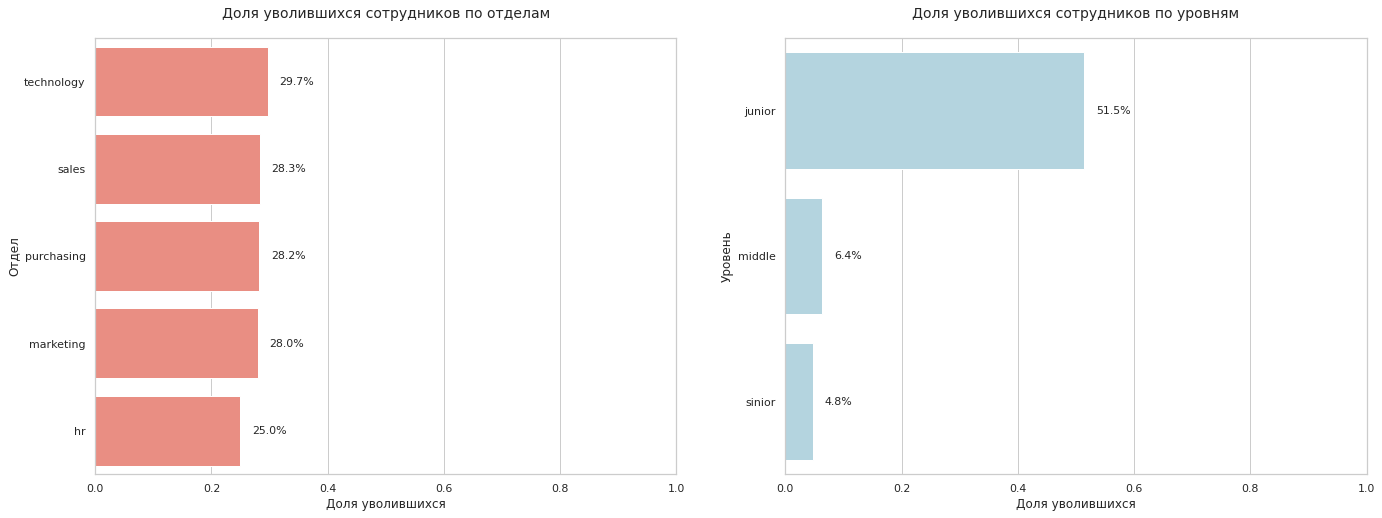

In [118]:
plt.figure(figsize=(20, 8))

# Объединяем данные всех сотрудников
train_all = pd.concat([train_quit_stable, train_quit_retired])

# --- График для отделов (левый) ---
plt.subplot(1, 2, 1)

# Считаем долю уволившихся по отделам
dept_total = train_all['dept'].value_counts()  # Все сотрудники по отделам
dept_quit = train_quit_retired['dept'].value_counts()  # Уволившиеся по отделам
dept_ratio = (dept_quit / dept_total).sort_values(ascending=False)

sns.barplot(x=dept_ratio.values, y=dept_ratio.index, color='salmon')
plt.title('Доля уволившихся сотрудников по отделам', pad=20, fontsize=14)
plt.xlabel('Доля уволившихся', fontsize=12)
plt.ylabel('Отдел', fontsize=12)
plt.xlim(0, 1)

# Добавляем проценты
for i, v in enumerate(dept_ratio.values):
    plt.text(v + 0.02, i, f"{v:.1%}", ha='left', va='center', fontsize=11)

# --- График для уровней (правый) ---
plt.subplot(1, 2, 2)

# Считаем долю уволившихся по уровням
level_total = train_all['level'].value_counts()  # Все сотрудники по уровням
level_quit = train_quit_retired['level'].value_counts()  # Уволившиеся по уровням
level_ratio = (level_quit / level_total).sort_values(ascending=False)

sns.barplot(x=level_ratio.values, y=level_ratio.index, color='lightblue')
plt.title('Доля уволившихся сотрудников по уровням', pad=20, fontsize=14)
plt.xlabel('Доля уволившихся', fontsize=12)
plt.ylabel('Уровень', fontsize=12)
plt.xlim(0, 1)

# Добавляем проценты
for i, v in enumerate(level_ratio.values):
    plt.text(v + 0.02, i, f"{v:.1%}", ha='left', va='center', fontsize=11)

plt.tight_layout(pad=3)
plt.show()

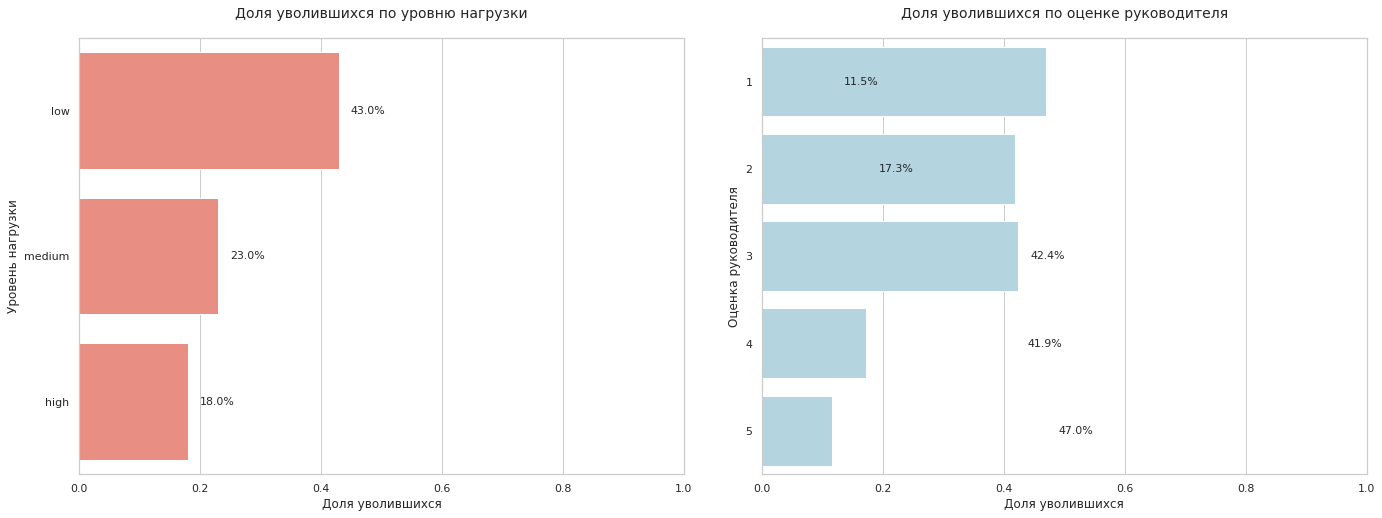

In [119]:
plt.figure(figsize=(20, 8))

# Объединяем данные всех сотрудников
train_all = pd.concat([train_quit_stable, train_quit_retired])

# --- График для workload (левый) ---
plt.subplot(1, 2, 1)

# Считаем долю уволившихся по уровню нагрузки
workload_total = train_all['workload'].value_counts()
workload_quit = train_quit_retired['workload'].value_counts()
workload_ratio = (workload_quit / workload_total).sort_values(ascending=False)

sns.barplot(x=workload_ratio.values, y=workload_ratio.index, color='salmon')
plt.title('Доля уволившихся по уровню нагрузки', pad=20, fontsize=14)
plt.xlabel('Доля уволившихся', fontsize=12)
plt.ylabel('Уровень нагрузки', fontsize=12)
plt.xlim(0, 1)

# Добавляем проценты
for i, v in enumerate(workload_ratio.values):
    plt.text(v + 0.02, i, f"{v:.1%}", ha='left', va='center', fontsize=11)

# --- График для supervisor_evaluation (правый) ---
plt.subplot(1, 2, 2)

# Считаем долю уволившихся по оценке руководителя
eval_total = train_all['supervisor_evaluation'].value_counts().sort_index(ascending=False)
eval_quit = train_quit_retired['supervisor_evaluation'].value_counts().sort_index(ascending=False)
eval_ratio = (eval_quit / eval_total)

sns.barplot(x=eval_ratio.values, y=eval_ratio.index.astype(str), 
            color='lightblue', order=eval_ratio.index.astype(str)[::-1])
plt.title('Доля уволившихся по оценке руководителя', pad=20, fontsize=14)
plt.xlabel('Доля уволившихся', fontsize=12)
plt.ylabel('Оценка руководителя', fontsize=12)
plt.xlim(0, 1)

# Добавляем проценты
for i, v in enumerate(eval_ratio.values):
    plt.text(v + 0.02, i, f"{v:.1%}", ha='left', va='center', fontsize=11)

plt.tight_layout(pad=3)
plt.show()

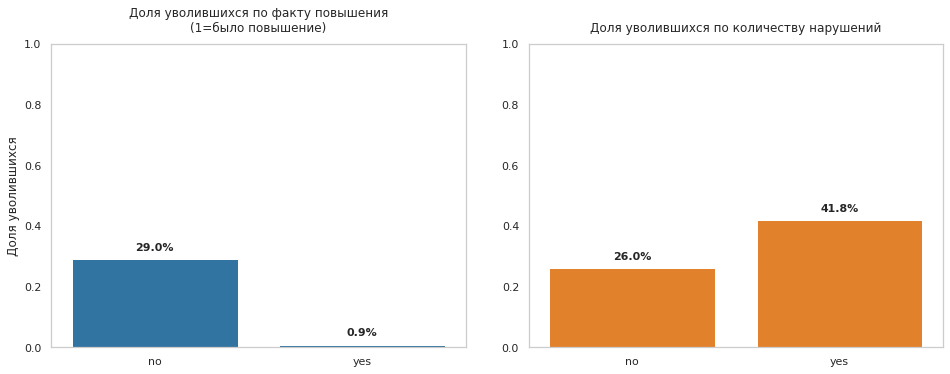

In [120]:
plt.figure(figsize=(14, 6))

# Объединяем данные всех сотрудников
train_all = pd.concat([train_quit_stable, train_quit_retired])

# --- График для повышений (левый) ---
plt.subplot(1, 2, 1)

# Считаем долю уволившихся по факту повышения
promo_total = train_all['last_year_promo'].value_counts().sort_index()
promo_quit = train_quit_retired['last_year_promo'].value_counts().sort_index()
promo_ratio = promo_quit / promo_total

sns.barplot(x=promo_ratio.index, y=promo_ratio.values, color='#1f77b4')
plt.title('Доля уволившихся по факту повышения\n(1=было повышение)', pad=12)
plt.xlabel('')
plt.ylabel('Доля уволившихся', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Аннотации
for i, v in enumerate(promo_ratio):
    plt.text(i, v+0.03, f"{v:.1%}", 
             ha='center', fontsize=11, fontweight='bold')

# --- График для нарушений (правый) ---
plt.subplot(1, 2, 2)

# Считаем долю уволившихся по количеству нарушений
viol_total = train_all['last_year_violations'].value_counts().sort_index()
viol_quit = train_quit_retired['last_year_violations'].value_counts().sort_index()
viol_ratio = viol_quit / viol_total

sns.barplot(x=viol_ratio.index, y=viol_ratio.values, color='#ff7f0e')
plt.title('Доля уволившихся по количеству нарушений', pad=12)
plt.xlabel('')
plt.ylabel('')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Аннотации
for i, v in enumerate(viol_ratio):
    plt.text(i, v+0.03, f"{v:.1%}", 
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout(pad=3)
plt.show()

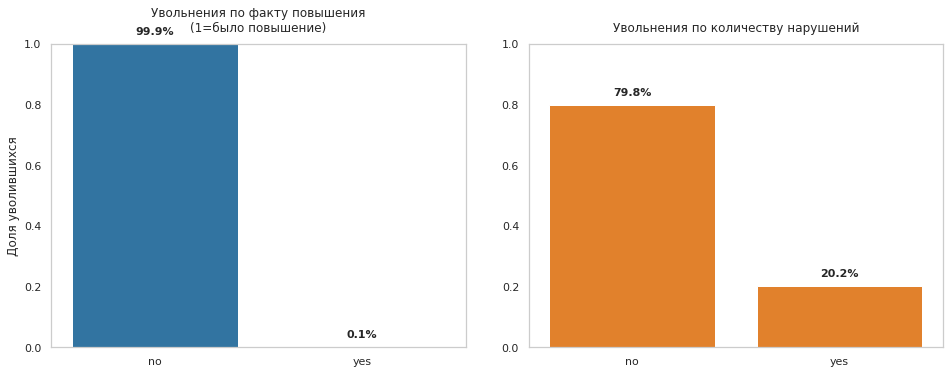

In [87]:
plt.figure(figsize=(14, 6))

# --- График для повышений (левый) ---
plt.subplot(1, 2, 1)
promo_stats = train_quit_retired['last_year_promo'].value_counts(normalize=True).sort_index()
sns.barplot(x=promo_stats.index, y=promo_stats.values, color='#1f77b4')  # Убрал width отсюда
plt.title('Увольнения по факту повышения\n(1=было повышение)', pad=12)
plt.xlabel('')
plt.ylabel('Доля уволившихся', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Аннотации
for i, v in enumerate(promo_stats):
    plt.text(i, v+0.03, f"{v:.1%}", 
             ha='center', fontsize=11, fontweight='bold')

# --- График для нарушений (правый) ---
plt.subplot(1, 2, 2)
viol_stats = train_quit_retired['last_year_violations'].value_counts(normalize=True).sort_index()
sns.barplot(x=viol_stats.index, y=viol_stats.values, color='#ff7f0e')  # Убрал width отсюда
plt.title('Увольнения по количеству нарушений', pad=12)
plt.xlabel('')
plt.ylabel('')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Аннотации
for i, v in enumerate(viol_stats):
    plt.text(i, v+0.03, f"{v:.1%}", 
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout(pad=3)
plt.show()

<font color='Black'><b>Опишем портрет уволившегося сотрудника: </b></font><br>

Среднестатистический уволившийся сотрудник junior имеет зарплату 23 тыс.руб., работает в компании 1-3 года , работал в отделе продаж или технологий, не получал повышений за последний год, уволившийся сотрудник допускал нарушения трудового договора и имел среднюю оценку(3) начальства за качество работы.

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределение признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

Для того чтобы сравнить распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников объединим таблицы test_target_job_satisfaction_rate и test_target_quit. 

In [88]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


In [89]:
test_target_quit.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [90]:
target = pd.merge(test_target_job_satisfaction_rate, test_target_quit, on = 'id', how = 'outer')
target.tail()

,id,job_satisfaction_rate,quit
1995,997290,0.79,no
1996,998548,0.76,yes
1997,998762,0.48,yes
1998,998900,0.57,no
1999,999029,0.35,yes


Для сравнения распределения признака job_satisfaction_rate у ушедших и оставшихся сотрудников разделим получившуюся таблицу

In [91]:
#список значений признака  job_satisfaction_rate оставшихся сотрудников
x1 = list(target[target['quit'] == 'no']['job_satisfaction_rate'])

#список значений признака  job_satisfaction_rate уволившихся сотрудников
x2 = list(target[target['quit'] == 'yes']['job_satisfaction_rate'])

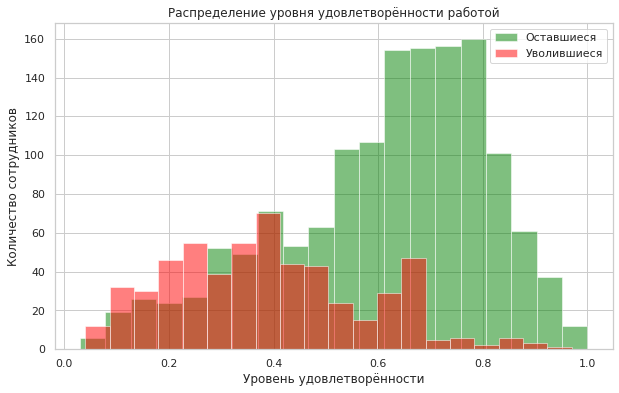

In [92]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.hist(x1, bins=20, alpha=0.5, color='green', label='Оставшиеся')
plt.hist(x2, bins=20, alpha=0.5, color='red', label='Уволившиеся')


plt.title('Распределение уровня удовлетворённости работой')
plt.xlabel('Уровень удовлетворённости')
plt.ylabel('Количество сотрудников')
plt.legend()
plt.show()

In [93]:
stable = target[target['quit'] == 'no']
retired = target[target['quit'] == 'yes']

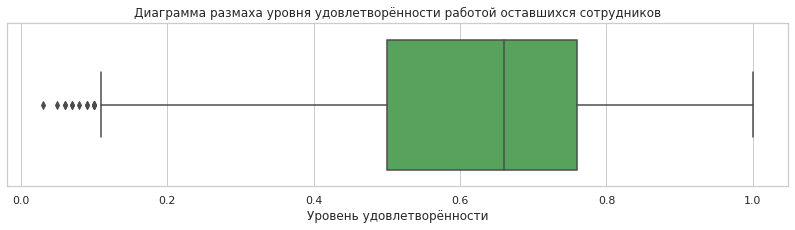

In [94]:
plt.figure(figsize=(14,3))
sns.boxplot(x='job_satisfaction_rate',data=stable, color='#4CAF50')
plt.title('Диаграмма размаха уровня удовлетворённости работой оставшихся сотрудников', fontsize=12)
plt.xlabel('Уровень удовлетворённости')
plt.show()

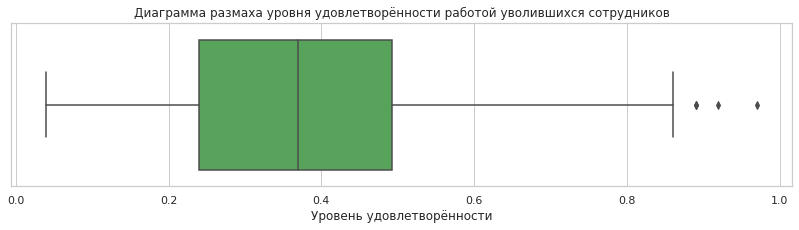

In [95]:
plt.figure(figsize=(14,3))
sns.boxplot(x='job_satisfaction_rate',data=retired, color='#4CAF50')
plt.title('Диаграмма размаха уровня удовлетворённости работой уволившихся сотрудников', fontsize=12)
plt.xlabel('Уровень удовлетворённости')
plt.show()

На гистограмме и диаграмме размаха отчетливо видно, что уровень удовлетворенности уволившихся сотрудников был низким относительно оставшихся сотрудников. 
- У оставшихся сотрудников средний уровень удовлетворенности около 0.7
- У уволившихся сотрудников средний уровень удовлетворенности около 0.3.

## Добавление нового входного признака

Мы выяснили, что job_satisfaction_rate и quit действительно связаны.
В первой задаче мы получили необходимое значение метрики, добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

Сделаем предсказания признака job_satisfaction_rate на данных train_quit_new с помощью лучшей модели из первой задачи:

In [96]:
# Уберем признак quit, тк его не было во входных признаках модели из первой задачи.
train_quit_new = train_quit.drop(['quit'], axis=1) 

In [97]:
job_satisf_pred = randomized_search.predict(train_quit_new)

In [98]:
train_quit['job_satisf_rate_pred'] = job_satisf_pred
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisf_rate_pred
2600,100222,sales,junior,medium,3,no,no,2,20400,yes,0.345158
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.333287
2455,100469,marketing,junior,medium,1,no,no,4,28800,no,0.641923
1592,100601,technology,middle,high,4,no,no,4,68400,no,0.666950
2657,100858,sales,junior,medium,2,no,no,4,25200,yes,0.826531
...,...,...,...,...,...,...,...,...,...,...,...
2194,998517,purchasing,middle,low,5,no,no,3,19200,no,0.375643
3701,999003,hr,middle,low,3,no,no,2,24000,yes,0.247633
3364,999158,purchasing,junior,medium,1,no,yes,1,21600,yes,0.086060
18,999835,sales,junior,low,5,no,no,4,18000,no,0.843766


Сделаем предсказания признака job_satisfaction_rate на данных test_features с помощью лучшей модели из первой задачи:

In [99]:
job_satisf_pred_test = randomized_search.predict(test_features)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [100]:
test_features['job_satisf_rate_pred'] = job_satisf_pred_test
test_features

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
1172,100298,hr,junior,low,2,no,no,4,19200,0.827758
852,100480,marketing,junior,low,4,no,no,4,16800,0.853774
848,100503,purchasing,middle,high,5,no,no,4,55200,0.771148
524,100610,sales,middle,medium,5,no,no,4,43200,0.813594
476,100692,sales,middle,high,6,no,no,4,48000,0.696831
...,...,...,...,...,...,...,...,...,...,...
1925,997290,sales,sinior,medium,7,no,no,4,58800,0.834045
1886,998548,marketing,junior,medium,2,no,no,4,32400,0.806179
506,998762,technology,junior,low,3,no,no,3,22800,0.499404
1579,998900,marketing,middle,medium,7,no,no,3,45600,0.435900


В тренировочную выборку (train_quit) и тестовую (test_features) добавили прогноз уровеня удовлетворённости сотрудника работой в компании (job_satisf_rate_pred), полученный с помощью лучшей модели первой задачи.

## Подготовка данных

Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании нужно учитывать особенности признаков и моделей и используем как минимум два кодировщика.

In [101]:
X_train_ = train_quit.drop(['id', 'quit'], axis=1)
y_train_ = train_quit['quit']

X_test_ = test_features.drop(['id'], axis=1)
y_test_ = test_target_quit['quit']

Закодируем целевой признак с помощью LabelEncoder:

In [102]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train_)

y_train_ = label_encoder.transform(y_train_)
y_test_ = label_encoder.transform(y_test_) 

In [103]:
X_train_.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisf_rate_pred'],
      dtype='object')

In [104]:
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']

num_columns = ['employment_years', 
               'supervisor_evaluation', 
               'salary',
               'job_satisf_rate_pred']

In [105]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [106]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes'],
                ], 
                handle_unknown='use_encoded_value' , unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [107]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Пайплайн подготовки данных готов. Переходим к обучению модели.

## Обучение модели

Обучим как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.

In [108]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [109]:
param = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            class_weight='balanced',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability = True)],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Метрика оценки качества в этой задаче — ROC-AUC. 

Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [110]:
randomized = RandomizedSearchCV(
    pipe_final, 
    param, 
    cv=10,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [111]:
randomized.fit(X_train_, y_train_)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord'...
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [112]:
print('Лучшая модель и её параметры:\n\n', randomized.best_estimator_)
print ('Метрика лучшей модели по кросс валидацинной выборке:', randomized.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                           

Лучшая модель по итогам отбора - KNeighborsClassifier, модель показала высокую метрику roc_auc 92,9%. Проверим результат работы лучше модели на тестовой выборке:

In [113]:
y_test_pred_ = randomized.predict(X_test_)
y_test_proba_ = randomized.predict_proba(X_test_)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_, y_test_proba_[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Модель прошла критерий успеха (ROC-AUC  ≥ 0.91)

## Выводы

<font color='Black'><b>Вывод после обучения модели:  </b></font><br>

Мы обучили 4 модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression  и SVC, в качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели мы использовали метрику ROC-AUC. По итогам подбора лучшей моделью стала модель  KNeighborsClassifier(n_neighbors=7). Метрика ROC-AUC на тестовой выборке - 0.91

# Общий вывод

Стояла задача помочь HR-аналитикам компании «Работа с заботой» оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

Было решено две задачи:
1) Построили модель, предсказывающая уровень удовлетворённости работой сотрудников на основе данных заказчика.

Для решения первой задачи обучили 4 модели: DecisionTreeRegressor, KNeighborsRegressor, RandomForestRegressor и LinearRegression, в качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели мы создали метрику SMAPE («симметричное среднее абсолютное процентное отклонение») По итогам подбора лучшей моделью стала модель RandomForestRegressor. Метрика SMAPE на тестовой выборке - 12.89%.

2) Построили модель, которая на основе данных заказчика предсказывает то, что сотрудник уволится из компании. 

Для решения второй задачи обучили 4 модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC, в качестве гипарпараметров использовали методы масштабирования, для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели мы использовали метрику ROC-AUC. По итогам подбора лучшей моделью стала модель KNeighborsClassifier(n_neighbors=7). Метрика ROC-AUC на тестовой выборке - 0.91.

Предложение для бизнеса: 

По итогам исследовательского анализа данных мы увидели, что:
- в основном увольняются сотрудники категории Junior;
- сотрудники, нарушавшие трудовой договор за последний год, имеют низкий уровень удовлетворённости работой в компании;
- у уровня удовлетворённости сотрудника работой в компании есть корреляция с оценкой качества работы сотрудника, которую дал руководитель.

Если начинающий специалист (Junior) нарушает трудовой договор и получает удовлетворительную (3) оценку качества работы от руководителя, то стоит обратить внимание на данного сотрудника, так как эти признаки говорят о том, что сотрудник не старается на работе, не дорожит этой компанией и потенциально готовится к уходу из компании. 
